# Breast Cancer Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict breast cancer with features derived from breast mass images**_

---


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Hosting)
  1. [Evaluate](#Evaluate)
1. [Extensions](#Extensions)
  1. [Hyperparameter Optimization](#Hyperparameter-Optimization)

---


## Background

This notebook illustrates the use of SageMaker's built-in XGBoost algorithm for binary classification.
XGBoost uses decision trees to build a predictive model.

### Why XGBoost and not Logistic Regression?

Whilst logistic regression is often used for classification exercises, it has some drawbacks. For example, additional feature engineering is required to deal with non-linear features.

XGBoost (an implementation of Gradient Boosted Trees) offers several benefits including naturally accounting for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.
Decision Tree algorithms such as XGBoost also have the added benefit of being able to deal with missing values in both the training dataset as well as unseen samples that are being used for inference.

Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint



---

## Setup

_This notebook was created and tested on an ml.t2.medium notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The SageMaker role arn used to give learning and hosting access to your data. The snippet below will use the same role used by your SageMaker notebook instance. If you wish to use a different role, specify the full ARN of a role with the SageMakerFullAccess policy attached.

In [ ]:
bucket = 'djenny-sagemaker-sydney'
prefix = 'sagemaker/DEMO-xgboost-churn'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
region = boto3.Session().region_name

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

---
## Data

For this illustration, we have taken an example for breast cancer prediction using UCI'S breast cancer diagnostic data set available at https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. The data set is also available on Kaggle at https://www.kaggle.com/uciml/breast-cancer-wisconsin-data. The purpose here is to use this data set to build a predictve model of whether a breast mass image indicates benign or malignant tumor. 

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
    
# You can find out all the details of this dataset here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

#Let's download the data and save it in the local folder with the name data.csv and take a look at it.

The dataset we downloaded does not have column headings; however this information is available at the source

More information about this dataset can be found here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
Sample images used in this dataset can be seen here: ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/cancer_images

- `id`: ID number
- `diagnosis`: The diagnosis of breast tissues (M = malignant, B = benign)
- `radius_mean`: mean of distances from center to points on the perimeter
- `texture_mean`: standard deviation of gray-scale values
- `perimeter_mean`: mean size of the core tumor
- `area_mean`: 
- `smoothness_mean`: mean of local variation in radius lengths
- `compactness_mean`: mean of perimeter^2 / area - 1.0
- `concavity_mean`: mean of severity of concave portions of the contour
- `concave points_mean`: mean for number of concave portions of the contour
- `symmetry_mean`: 
- `fractal_dimension_mean`: mean for "coastline approximation" - 1
- `radius_se`: standard error for the mean of distances from center to points on the perimeter
- `texture_se`: standard error for standard deviation of gray-scale values
- `perimeter_se`: 
- `area_se`: 
- `smoothness_se`: standard error for local variation in radius lengths
- `compactness_se`: standard error for perimeter^2 / area - 1.0
- `concavity_se`: standard error for severity of concave portions of the contour
- `concave points_se`: standard error for number of concave portions of the contour
- `symmetry_se`: 
- `fractal_dimension_se`: standard error for "coastline approximation" - 1
- `radius_worst`: "worst" or largest mean value for mean of distances from center to points on the perimeter
- `texture_worst`: "worst" or largest mean value for standard deviation of gray-scale values
- `perimeter_worst`: 
- `area_worst`: 
- `smoothness_worst`: "worst" or largest mean value for local variation in radius lengths
- `compactness_worst`: "worst" or largest mean value for perimeter^2 / area - 1.0
- `concavity_worst`: "worst" or largest mean value for severity of concave portions of the contour
- `concave points_worst`: "worst" or largest mean value for number of concave portions of the contour
- `symmetry_worst`: 
- `fractal_dimension_worst`: "worst" or largest mean value for "coastline approximation" - 1


If we load this CSV data into a pandas dataframe, we can easily take a closer look


In [ ]:
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
                "compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean",
                "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
                "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
                "perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst",
                "concave points_worst","symmetry_worst","fractal_dimension_worst"]
breastcancer = pd.read_csv('./wdbc.data', header=None, names=col_names)
breastcancer

The breast cancer dataset is quite small, with only 569 records, where each record uses 32 attributes to describe the profile of a breast mass.
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image

Let's see which of our colums are of type string

In [ ]:
breastcancer.select_dtypes(include=['object'])

Only one column is of type string, and that is the diagnosis. Lets take a look at the diagnosis distribution in both absolute and normalised forms:

In [ ]:
display(pd.crosstab(index=breastcancer['diagnosis'], columns='% observations'))
display(pd.crosstab(index=breastcancer['diagnosis'], columns='% observations', normalize='columns'))

So 63% of our samples are benign and 37% are malignant. This is a reasonable spread

Next we will take a closer look at all of the numeric features in the dataset

In [ ]:
display(breastcancer.describe())

It will be more useful to look at the histograms of the numerical features

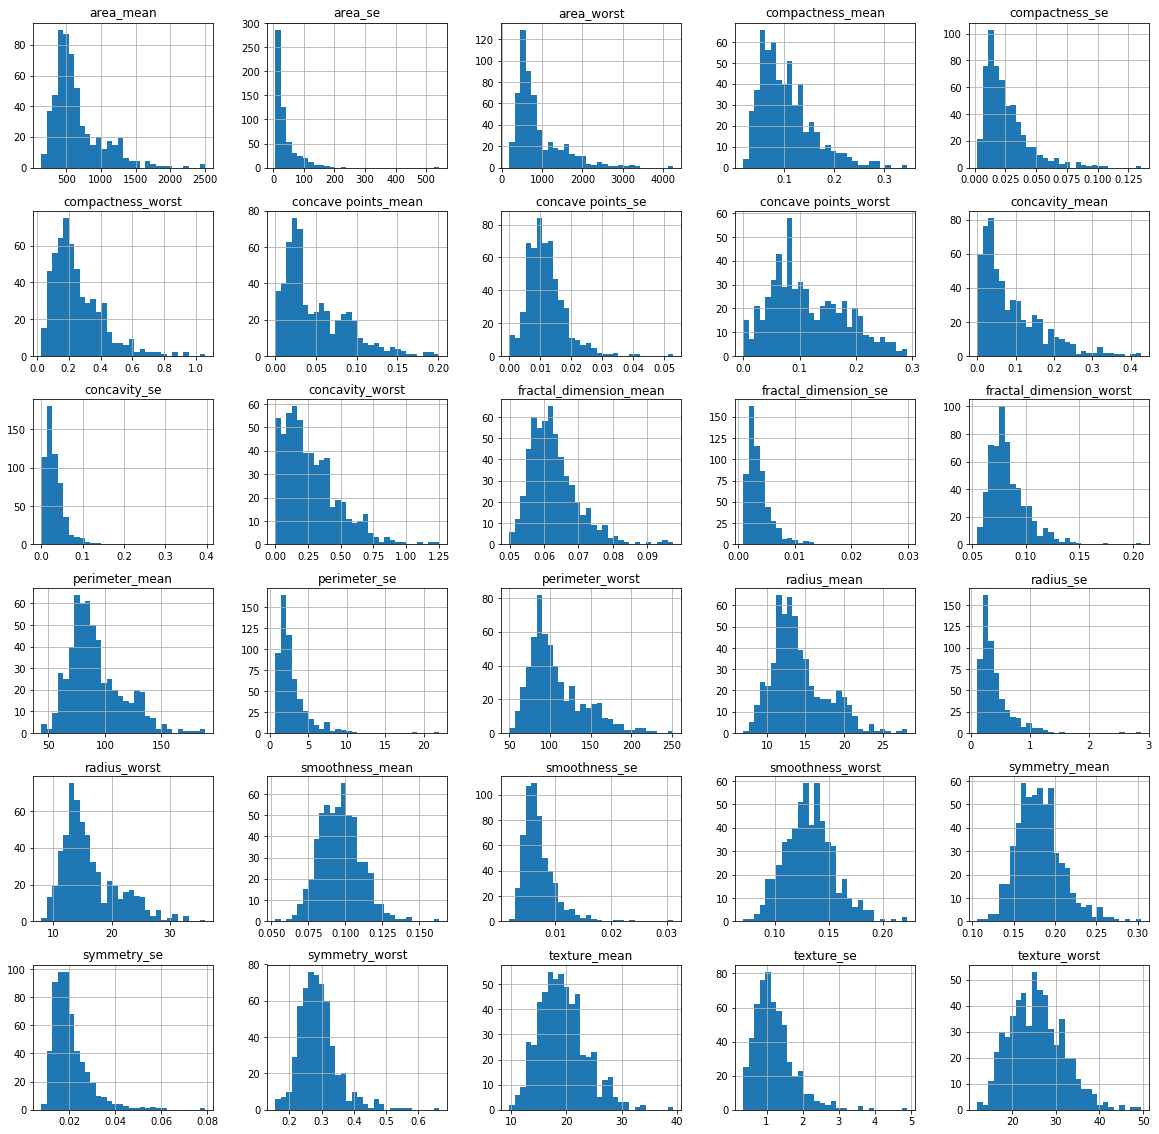

In [206]:
%matplotlib inline
hist = breastcancer.hist(bins=30, sharey=False, figsize=(20, 20))

From these histograms we can see that:
- Most of the numeric features are nicely distributed, with some even showing bell-like gaussianity.
- `id` should not be included as a feature (and it should be converted to non-numeric) 


We will drop the `id` column from the dataset:


In [ ]:
breastcancer = breastcancer.drop(['id'], axis=1)

#### Note for future reference:
There may be scenarios where you have a numeric field like `id` that did add some non-numeric value.
A good example would be if the first N characters of patient ID indicated the country or state where the patient was located and you wanted to see if this location had any bearing on the diagnosis.
In such a case you would convert the field to a string:
<pre><code>breastcancer['id'] = breastcancer['id'].astype(object)</code></pre>
and extract the pertinant information.
You would then treat that field as a categorical field


To take a look at the relationship between any categorical fields and the final diagnosis, you would use the following cross-tabulation report: 
<pre><code>for column in breastcancer.select_dtypes(include=['object']).columns:
    if column != 'diagnosis':
        display(pd.crosstab(index=breastcancer[column], columns=breastcancer['diagnosis'], normalize='columns'))
</code></pre>

Now we will look at the direct relationship between numeric (non-object) values and diagnosis. We do this by plotting a histogram for every numeric value.
We divide our samples into `bins`. The X-axis represents the bins and the Y-axis represents how many samples fall into each bin.
By forcing the benign and malignant graphs to share the same X and Y scale it is easier to visualise which bins are more populated between the two diagnoses.

Feel free to adjust the number of bins being plotted by the histogram and view the effect.

radius_mean


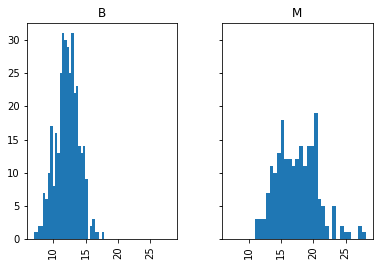

texture_mean


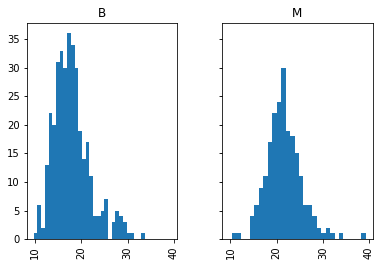

perimeter_mean


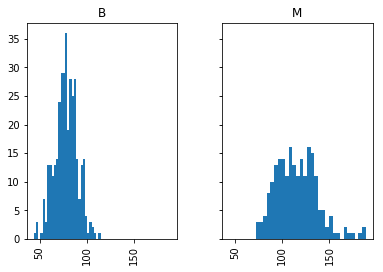

area_mean


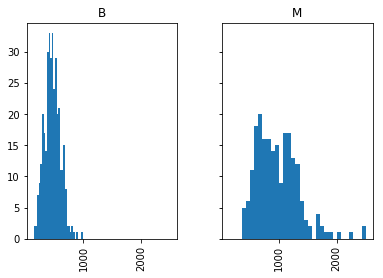

smoothness_mean


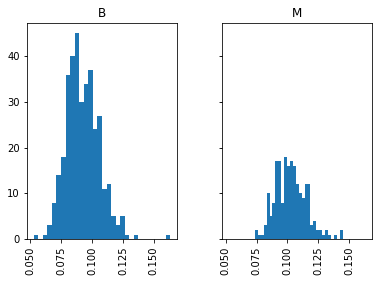

compactness_mean


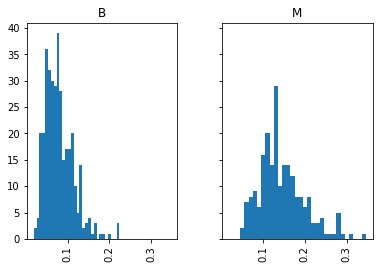

concavity_mean


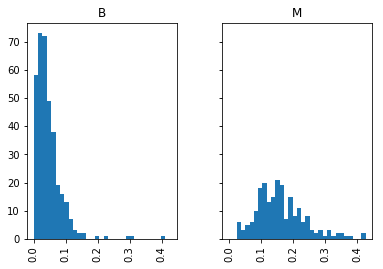

concave points_mean


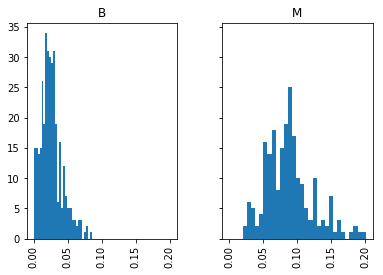

symmetry_mean


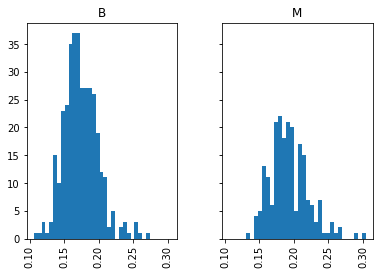

fractal_dimension_mean


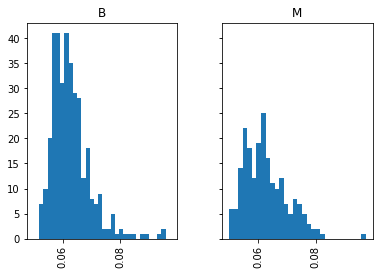

radius_se


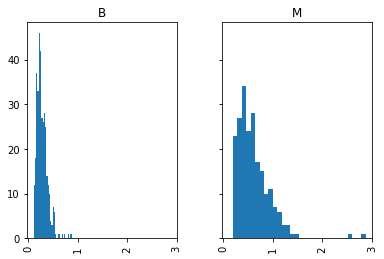

texture_se


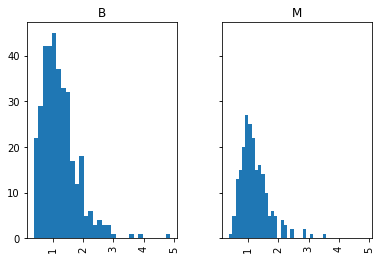

perimeter_se


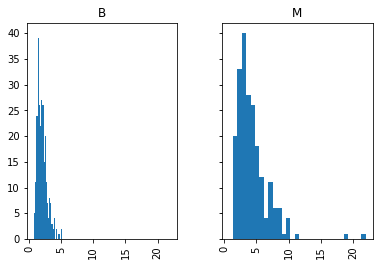

area_se


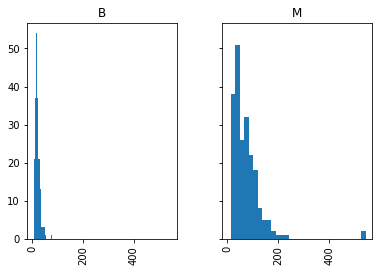

smoothness_se


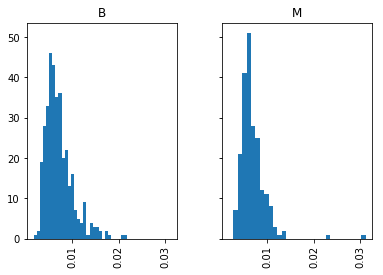

compactness_se


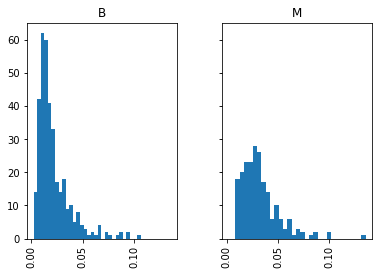

concavity_se


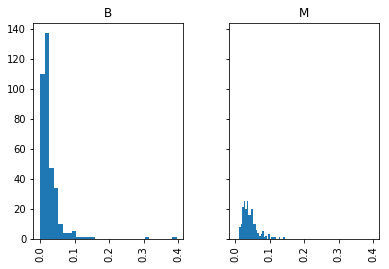

concave points_se


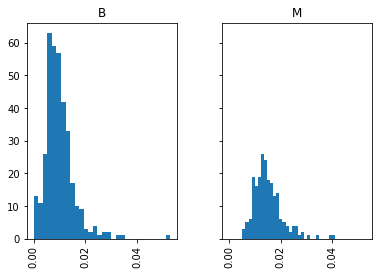

symmetry_se


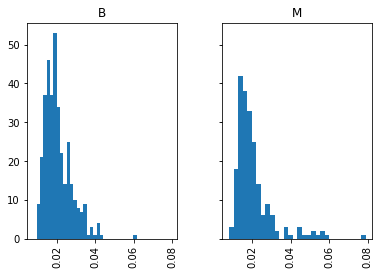

fractal_dimension_se


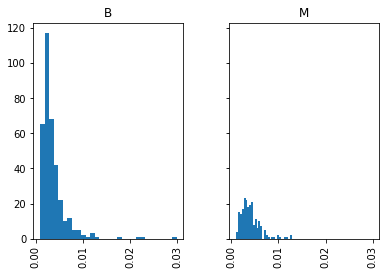

radius_worst


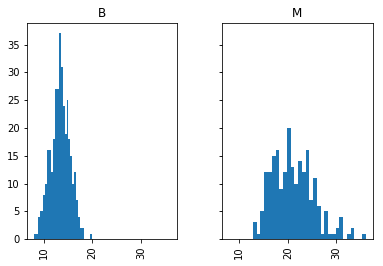

texture_worst


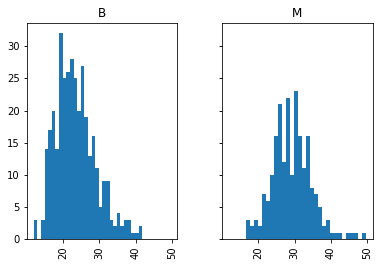

perimeter_worst


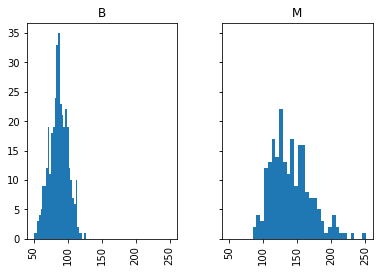

area_worst


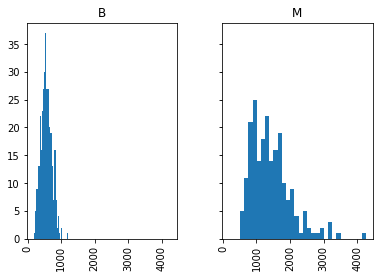

smoothness_worst


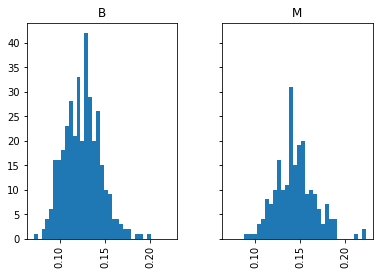

compactness_worst


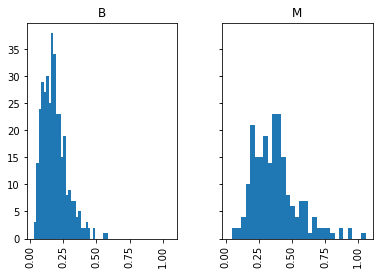

concavity_worst


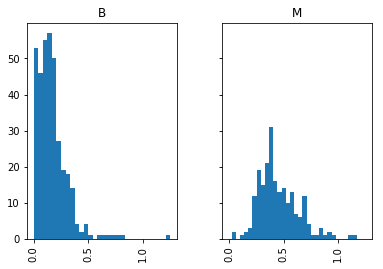

concave points_worst


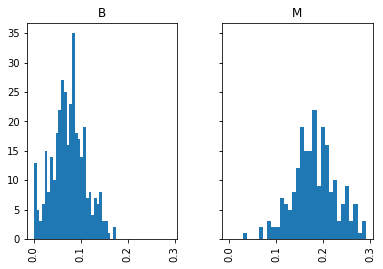

symmetry_worst


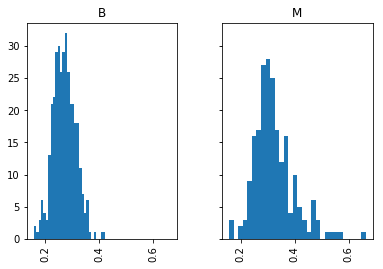

fractal_dimension_worst


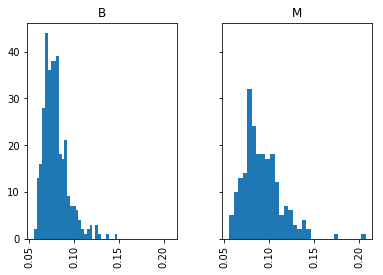

In [211]:
for column in breastcancer.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = breastcancer[[column, 'diagnosis']].hist(by='diagnosis', sharey=True, sharex=True, bins=30)
    plt.show()

What can we infer from these relationships?

We see that malignant diagnosis appear to have higher values for the following features:
- radius_mean
- perimeter_mean
- area_mean
- compactness_mean
- concavity_mean
- concave points_mean
- radius_se
- area_se
- radius_worst
- texture_worst
- perimeter_worst
- area_worst
- compactness_worst
- concavity_worst
- concave points_worst

We see similar distributions for features such as `radius_mean`, `perimeter_mean` and `area_mean` for both malignant and benign diagnosis. This makes sense as each of these features are related to the size of the tumour.

Let's dig deeper into the relationships between our features by computing the pairwise correlation of columns.

In [213]:
display(breastcancer.corr())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


We see several features that essentially have a strong (but not 100%) correlation with one another.

One such example is radius_mean and perimeter_mean which have a correlation score of 0.997855

It can be easier to see correlations using a scatter matrix


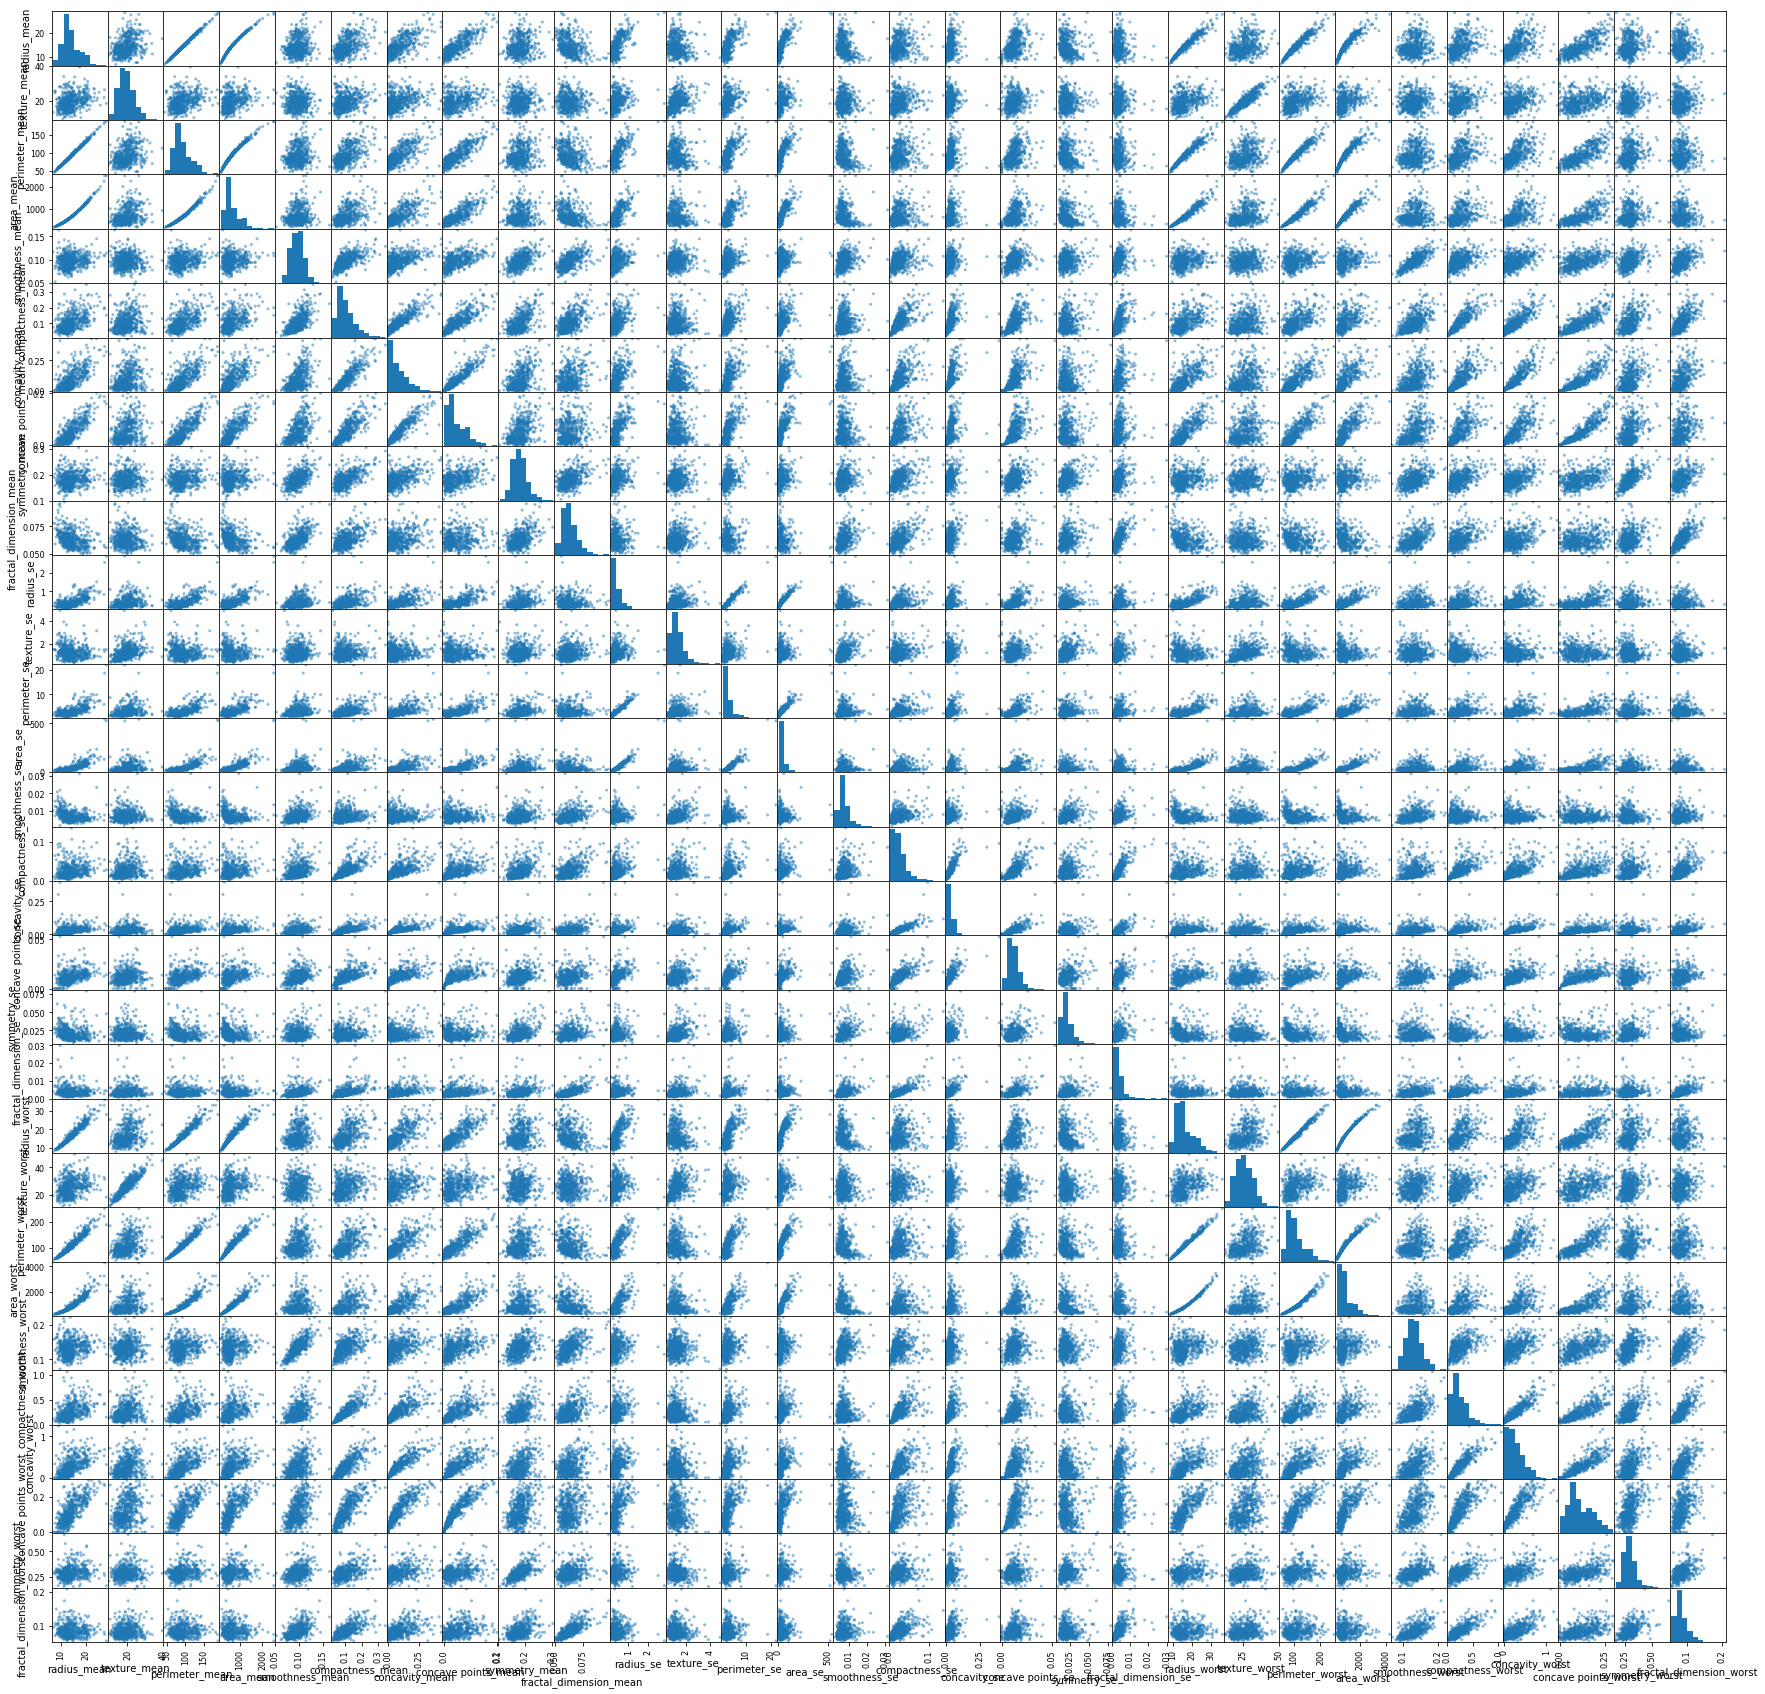

In [215]:
pd.plotting.scatter_matrix(breastcancer, figsize=(30, 30))
plt.show()

In the scatter matrix, such strongly correlated features are indicated by a diagonal line running from bottom left to top right. In the correlation matrix, such relationships are indicated by a correlation value close to 1.

In some cases it can be a good idea to remove one element of a highly correlated feature pair. 
For the first run of our training, I am going to leave all data in; however, it would be a valuable exercise to remove the following values and compare results of the final model:
`perimeter_mean` and `area_mean` - since `radius_mean` has high correlation (>98%) with those measurements.
A further exercise would be to remove one of a feature pair that have more than 96% correlation and compare final predictive results of the models. This is the 'scientific experimentation' side of data science.

For reference, the command to drop columns from the pandas dataframe is:

<pre><code>breastcancer = breastcancer.drop(['ColName1', 'ColName2'], axis=1)</code></pre>

Now that we have a clean dataset (and have potentially removed some unneccessary columns), we can prepare the dataset for XGBoost. 

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Contain only numeric values
- Have the predictor variable in the first column
- Not have a header row

We will also
- Shuffle the dataset
- Split the dataset into training, validation and testing sets

### Step 1: Convert our categorical features into numeric features using the "get_dummies" function which will automatically convert categorical variable into dummy/indicator variables.

I have shown the first and last row of the dataset in order to illustrate the output of the 'get_dummies' method.

Since our only categorical variable is 'diagnosis', you will see that it now appears as the last column(s) of the new dataset broken up into one column per diagnosis label.

In [218]:
pd.set_option('max_rows', 3)
display(breastcancer)
model_data = pd.get_dummies(breastcancer)
display(model_data)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.1471,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.0000,0.0000,0.1587,0.05884,0.3857,1.4280,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_B,diagnosis_M
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.1471,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.0000,0.0000,0.1587,0.05884,0.3857,1.4280,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1,0


### Step 2: Select a single predictor variable and bring it forward to the first column

Now we will keep only one of the predictor variables `diagnosis_M` which is our label for the tumour being malignant. We will append this column to a version of our dataset that drops the predictor columns (as XGBoost requires the predictor variable as the first column)

In [219]:
model_data = pd.concat([model_data['diagnosis_M'], model_data.drop(['diagnosis_B', 'diagnosis_M'], axis=1)], axis=1)
display(model_data)

,diagnosis_M,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.1471,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.0000,0.0000,0.1587,0.05884,0.3857,1.4280,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

### Step3: Shuffle the input dataset

We will shuffle the order of the dataset so as to reduce variance and ensure that the resultant model remains general.

We do this with the `sample` method.
I am specifying a value for `random state` only for the purposes of reproducability
Setting `frac`=1 specifies to keep all the samples, as opposed to returning a fraction of the samples

In [221]:
#breastcancer
shuffled_data=model_data.sample(frac=1, random_state=1)
display(shuffled_data)
pd.reset_option('max_rows')

,diagnosis_M,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
421,0,14.69,13.98,98.22,656.1,0.10310,0.18360,0.145000,0.063000,0.2086,0.07406,0.5462,1.5110,4.7950,49.450,0.009976,0.052440,0.052780,0.015800,0.026530,0.005444,16.46,18.34,114.10,809.2,0.13120,0.36350,0.321900,0.110800,0.2827,0.09208
47,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.122600,0.073400,0.2128,0.06777,0.2871,0.8937,1.8970,24.250,0.006532,0.023360,0.029050,0.012150,0.017430,0.003643,15.67,27.95,102.80,759.4,0.17860,0.41660,0.500600,0.208800,0.3900,0.11790
292,0,12.95,16.02,83.14,513.7,0.10050,0.07943,0.061550,0.033700,0.1730,0.06470,0.2094,0.7636,1.2310,17.670,0.008725,0.020030,0.023350,0.011320,0.026250,0.004726,13.74,19.93,88.81,585.4,0.14830,0.20680,0.224100,0.105600,0.3380,0.09584
186,1,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.081690,0.058140,0.1621,0.05425,0.2577,0.4757,1.8170,28.920,0.002866,0.009181,0.014120,0.006719,0.010690,0.001087,21.31,26.36,139.20,1410.0,0.12340,0.24450,0.353800,0.157100,0.3206,0.06938
414,1,15.13,29.81,96.71,719.5,0.08320,0.04605,0.046860,0.027390,0.1852,0.05294,0.4681,1.6270,3.0430,45.380,0.006831,0.014270,0.024890,0.009087,0.031510,0.001750,17.26,36.91,110.10,931.4,0.11480,0.09866,0.154700,0.065750,0.3233,0.06165
132,1,16.16,21.54,106.20,809.8,0.10080,0.12840,0.104300,0.056130,0.2160,0.05891,0.4332,1.2650,2.8440,43.680,0.004877,0.019520,0.022190,0.009231,0.015350,0.002373,19.47,31.68,129.70,1175.0,0.13950,0.30550,0.299200,0.131200,0.3480,0.07619
161,1,19.19,15.94,126.30,1157.0,0.08694,0.11850,0.119300,0.096670,0.1741,0.05176,1.0000,0.6336,6.9710,119.300,0.009406,0.030550,0.043440,0.027940,0.031560,0.003362,22.03,17.81,146.60,1495.0,0.11240,0.20160,0.226400,0.177700,0.2443,0.06251
197,1,18.08,21.84,117.40,1024.0,0.07371,0.08642,0.110300,0.057780,0.1770,0.05340,0.6362,1.3050,4.3120,76.360,0.005530,0.052960,0.061100,0.014440,0.021400,0.005036,19.76,24.70,129.10,1228.0,0.08822,0.19630,0.253500,0.091810,0.2369,0.06558
245,0,10.48,19.86,66.72,337.7,0.10700,0.05971,0.048310,0.030700,0.1737,0.06440,0.3719,2.6120,2.5170,23.220,0.016040,0.013860,0.018650,0.011330,0.034760,0.003560,11.48,29.46,73.68,402.8,0.15150,0.10260,0.118100,0.067360,0.2883,0.07748
453,0,14.53,13.98,93.86,644.2,0.10990,0.09242,0.068950,0.064950,0.1650,0.06121,0.3060,0.7213,2.1430,25.700,0.006133,0.012510,0.016150,0.011360,0.022070,0.003563,15.80,16.93,103.10,749.9,0.13470,0.14780,0.137300,0.106900,0.2606,0.07810


### Step 4: Split the dataset

Split our data into a training dataset, validation dataset and test dataset.

The ratio we will use is:
- Training dataset - 70%
- Validation dataset - 20%
- Test dataset - 10%

We do this using the numpy `split` function specifying splits at the 70% mark and the 90% mark of the shuffled dataset

In [222]:
train_data, validation_data, test_data = np.split(shuffled_data, [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
print("Training data sample size:",len(train_data))
print("Validation data sample size:",len(validation_data))
print("Test data sample size:",len(test_data))


Training data sample size: 398
Validation data sample size: 114
Test data sample size: 57


We need to convert the training dataset and validation dataset to CSV and upload to S3 for consumption by the containers running the XGBoost algorithm

In [223]:
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [224]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [ ]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on the GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [234]:
%%time
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.1,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-06-17 01:58:36 Starting - Starting the training job...
2019-06-17 01:58:38 Starting - Launching requested ML instances......
2019-06-17 01:59:43 Starting - Preparing the instances for training......
2019-06-17 02:01:05 Downloading - Downloading input data
2019-06-17 02:01:05 Training - Downloading the training image..
Arguments: train
[2019-06-17:02:01:16:INFO] Running standalone xgboost training.
[2019-06-17:02:01:16:INFO] File size need to be processed in the node: 0.13mb. Available memory size in the node: 8430.28mb
[2019-06-17:02:01:16:INFO] Determined delimiter of CSV input is ','
[02:01:16] S3DistributionType set as FullyReplicated
[02:01:16] 398x30 matrix with 11940 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-06-17:02:01:16:INFO] Determined delimiter of CSV input is ','
[02:01:16] S3DistributionType set as FullyReplicated
[02:01:16] 114x30 matrix with 3420 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=


## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [228]:
%%time
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.t2.medium')

ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:ap-southeast-2:493843837665:endpoint/xgboost-2019-06-17-01-33-48-414".

## Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [229]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Extract the features for each sample 
1. Retrieve the prediction for each sample by invoking the XGBoost endpoint
1. Collect predictions and convert from a python list to a NumPy array

In [230]:
# Convert the dataframe to a numpy array
dtest = test_data.to_numpy()

# As expected, the numpy array has 57 rows (57 samples in the test dataset), and 31 columns (30 features + 1 label)
#print(dtest.shape)

# Create a list to hold all of our predictions
predictions = []

# Loop through the matrix of our test data samples, pulling out the features for each sample and running inference
# Note: dtest[i:i+1, 1:] is an vector of all the features for the sample i (without the first entry which is the label)
for i in range(dtest.shape[0]):
    sample_features=dtest[i:i+1, 1:]
    prediction=xgb_predictor.predict(sample_features).decode('utf-8')
    predictions.append(float(prediction))
       
# Convert our list of predictions to a numpy array
predictions = np.asarray(predictions)
display(predictions)

array([0.9848668 , 0.01281791, 0.06503402, 0.00942292, 0.00942292,
       0.42644101, 0.96037561, 0.98330897, 0.06692716, 0.0165361 ,
       0.96398997, 0.94931823, 0.9816305 , 0.98859465, 0.06048676,
       0.01527873, 0.00846231, 0.97733456, 0.95546246, 0.01160521,
       0.0127839 , 0.03795663, 0.00942292, 0.01236734, 0.00950063,
       0.09821139, 0.0164849 , 0.99020946, 0.25925037, 0.00846231,
       0.09344126, 0.00942292, 0.01793692, 0.0093426 , 0.97420269,
       0.99126279, 0.88518685, 0.30092999, 0.01206367, 0.97041881,
       0.77654392, 0.00973383, 0.04212309, 0.98482394, 0.98488742,
       0.01357029, 0.97062498, 0.00846231, 0.033891  , 0.01699985,
       0.00942292, 0.23929536, 0.98814338, 0.00846231, 0.99126279,
       0.04984598, 0.00846231])

To evaluate the performance of this machine learning model on the test dataset, we will use a simple confusion matrix to compare actual to predicted values.  In this case, we're predicting whether the tumor was malignant (`1`) or benign (`0`).

- We get the actual values from the first column (column 0) of the dataset: `test_data.iloc[:, 0]`
- We get the predicted values from our array of predictions: `predictions`. We will simply round the predictions to the nearest integer (so a prediction < 0.5 will be 0 - benign and a prediction => 0.5 will be 1 - malignant)

In [231]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,34,0
1,3,20


Of the 57 samples in the test dataset, 34 were for benign tumours and indeed we've correctly predicted all 34 of them.
23 of the samples were malignant and we correctly predicted 20 of them.
3 of of the malignant samples were incorrectly predicted as benign

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  

However, because we would rather err on the side of a false positive than a false negative, we will adjust this cutoff. 

To get a rough intuition here, let's look at the continuous values of our predictions.

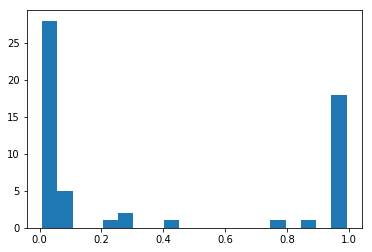

In [232]:
plt.hist(predictions, bins=20)
plt.show()

The continuous valued predictions coming from our model are generally quite decisive so tend to skew toward 0 or 1; however there are a few values between 0.1 and 0.9 where the model is less confident.

How you adjust the cutoff is completely dependent upon the problem space you are addressing and whether you want to have more likelihood of false positives or false negatives.

In the case of predicting malignant tumours we will be somewhat conservative and report any prediction greater than 0.3 as malignant 

In [233]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0), rownames=['actual'], colnames=['predictions'])

predictions,0,1
actual,,
0,34,0
1,1,22


We can see that changing the cutoff from 0.5 to 0.3 yields improved results. 

There is still 1 malignant sample that is being incorrectly predicted as benign. This would certainly require further investigation, hyperparameter tuning and likely even an ensemble approach where the prediction from this model are combined with the predictions of other models in order to vote for the final prediction.

---
## Extensions

### Hyperparameter-Optimization

Set our static hyperparameters


In [249]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

container = get_image_uri(region, 'xgboost', repo_version='latest')

xgb_hpo = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb_hpo.set_hyperparameters(objective='binary:logistic',
                        num_round=100)

Set our hyperparameters that we want SageMaker to tune

In [248]:
hyperparameter_ranges = {'eta': ContinuousParameter(0.2, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'gamma': ContinuousParameter(0, 20),
                        'subsample': ContinuousParameter(0.8, 1),
                        'max_depth': IntegerParameter(4, 10)}

objective_metric_name = 'validation:auc'

Define the hyperparameter tuning job

In [243]:
tuner = HyperparameterTuner(xgb_hpo,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

Run the hyperparameter tuning job

In [244]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

### Check job name and status of HPO job

In [247]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
print(tuner.latest_tuning_job.job_name)

xgboost-190617-0212


### Analyze tuning job results - after tuning job is completed
Please refer to "HPO_Analyze_TuningJob_Results.ipynb" to see example code to analyze the tuning job results.

### (Optional) Clean-up

If you're finished with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)